In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
from sklearn import metrics



import os, glob, inspect, sys, time, warnings


currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib' from '/home/marie-anne/code/Oct20_EPRI/Task1/NB/epri_mc_lib.py'>

# Import data

In [3]:
data_path = "../../Data/Merged_data"
df = pd.read_csv(os.path.join(data_path, 'ALL_TUBE_PIPE_simulated.csv'), 
                 index_col=0)
df.head()

,TEP_mean_uV_C,Absorption_avg_500,backscatter_avg,Absorption_avg_50,A,B,p,Absorption_avg_100,Absorption_avg_200,mean_CF,mean_perm,mean_MBN
Condition,,,,,,,,,,,,
T_B1,12.887224,0.000252,0.020317,0.001931,1.202073e-07,0.001092,0.221759,0.000886,0.000301,1.087656,68.832934,0.453917
T_B1,12.904167,0.000194,0.011580,0.001121,2.614525e-08,0.000801,0.214616,0.000605,0.000316,1.094037,67.753088,0.435966
T_B1,12.848012,0.000247,0.027738,0.001309,-3.440295e-07,0.000691,0.173157,0.000556,0.000428,1.098203,67.872952,0.539143
T_B1,12.968064,0.000210,0.019859,0.001921,-5.656336e-07,0.000864,0.213791,0.000746,0.000602,1.117724,65.970169,0.301158
T_B1,12.927068,0.000233,0.013641,0.001425,4.191747e-07,0.000408,0.192750,0.000777,0.000419,1.095836,68.614324,0.472276


## Calculating new values

In [4]:
df['AUC_avg'] = mc.findAUC(df, A=df['A'], B=df['B'], p=df['p'], name='AUC_avg')
df.drop(columns=["A","B","p"],inplace=True)

In [5]:
#df['CF_perm'] = df['mean_CF']/df['mean_perm'].astype('float64')
df.drop(columns=["mean_MBN","mean_CF"],inplace=True)

In [6]:
df.drop(columns=["Absorption_avg_500","Absorption_avg_200"],inplace=True)

## Scaling values

In [7]:
scaled_df = mc.scale_general(df, MinMaxScaler())[0]
scaled_df.head()

,TEP_mean_uV_C,backscatter_avg,Absorption_avg_50,Absorption_avg_100,mean_perm,AUC_avg
Condition,,,,,,
T_B1,0.867389,0.398567,0.371884,0.448386,0.420772,0.299520
T_B1,0.873593,0.249685,0.264753,0.355158,0.408741,0.257246
T_B1,0.853029,0.525029,0.289641,0.338891,0.410076,0.209584
T_B1,0.896992,0.390772,0.370632,0.402020,0.388876,0.242839
T_B1,0.881979,0.284809,0.304966,0.412269,0.418336,0.213235


## Selecting sub samples

In [8]:
tube, pipe, tube_wo_blind, tube_blind = mc.get_subsample_df(scaled_df)

In [9]:
tube.head()

,TEP_mean_uV_C,backscatter_avg,Absorption_avg_50,Absorption_avg_100,mean_perm,AUC_avg
Condition,,,,,,
T_B1,0.867389,0.398567,0.371884,0.448386,0.420772,0.299520
T_B1,0.873593,0.249685,0.264753,0.355158,0.408741,0.257246
T_B1,0.853029,0.525029,0.289641,0.338891,0.410076,0.209584
T_B1,0.896992,0.390772,0.370632,0.402020,0.388876,0.242839
T_B1,0.881979,0.284809,0.304966,0.412269,0.418336,0.213235


# Clustering

- **MeanShift**: [`MeanShift`](https://sklearn.org/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift)

- **K-Means**:
[`KMeans`](https://sklearn.org/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)

- **Agglomerative Hierarchical Clustering**:
[`AgglomerativeClustering`](https://sklearn.org/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)

- **Ward**:
[`AgglomerativeClustering`](https://sklearn.org/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)

- **Spectral Clustering**:
[`SpectralClustering`](https://sklearn.org/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering)

- **DBSCAN**:
[`DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html)
    
- **OPTICS**:
[`OPTICS`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html)

- **BIRCH**:
[`BIRCH`]([`BIRCH`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html)

- **Gaussian Mixture**:
[`GaussianMixture`](https://scikit-learn.org/stable/modules/mixture.html#gmm)

- **Bayesian Gaussian Mixture**:
[`BayesianGaussianMixture`](https://scikit-learn.org/stable/modules/mixture.html#gmm)


In [10]:
np.random.seed(42)
random_state = 42

default_base = {'quantile': .115, #for bandwidth of RBF kernel in meanshift
                'eps': 0.3, #max distance between 2 samples for DBSCAN
                'metric': 'minkowski', #for DBSCAN
                'damping': .1, #for Affinity Propagation:the extent to which the current value is maintained relative to incoming values
                'preference': -200, #for Affinity Propagation: each point - points with larger values of preferences are more likely to be chosen as exemplars.
                'n_neighbors': 5, #for k-neighbors graph for the connectivity matrix
                'n_clusters': 5, #for kmeans, ward, spectral, meanshift, BIRCH
                #for kmeans determine on elbow cf model_kmeans_simulated.ipynb
                'xi': 0.02, #for OPTICS Determines the minimum steepness on the reachability plot that constitutes a cluster boundary.
                'min_cluster_size': 0.1, # for optics Minimum number of samples in an OPTICS cluster, expressed as an absolute number or a fraction of the number of samples
                'threshold': 0.05, #for BIRCH to limit the samples per leaf node 
                'random_state': random_state
               }

datasets = [
    #(tube, {}),
    (tube_wo_blind, {})
    #(tube_blind, {})
]

In [11]:
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X  = dataset

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward (if need see jelly roll example)
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth)
    two_means = cluster.KMeans(n_clusters=params['n_clusters']) #use minibatch if too heavy
    ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
    average_linkage = cluster.AgglomerativeClustering(linkage="ward", affinity="euclidean", n_clusters=params['n_clusters'])
    spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors") #can also be rbf
    dbscan = cluster.DBSCAN(eps=params['eps'])
    #affinity_propagation = cluster.AffinityPropagation(damping=params['damping'], preference=params['preference'])
    optics = cluster.OPTICS(xi=params['xi'], min_cluster_size=params['min_cluster_size'])
    birch = cluster.Birch(n_clusters=params['n_clusters'], threshold=params['threshold'])
    gmm = mixture.GaussianMixture(n_components=params['n_clusters'], covariance_type='full')
    bgmm = mixture.BayesianGaussianMixture(n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('Kmeans', two_means),
        #('AffinityPropagation', affinity_propagation), EXCLUDED because of high complexity, most appropriate for small to medium sized datasets
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm),
        ('BayesianGaussianMixture', gmm)
    )

    labels = pd.DataFrame(index=X.index)
    score = pd.DataFrame()
    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="the number of connected components of the " + "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",category=UserWarning)
            warnings.filterwarnings("ignore", message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.", category=UserWarning)
            
            algorithm.fit(X)

        t1 = time.time()
        
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
        
        labels['label_' + name] = y_pred
        
        #silhouette = metrics.silhouette_score(X, labels['label_' + name], metric='euclidean')
        #score['silhouette_' + name] = silhouette

    results = pd.concat([X, labels], axis=1)

# Perform PCA to plot all dimension (n_components = 2)

In [12]:
pca = PCA(n_components=2, svd_solver='full')
transformed = pca.fit_transform(X)
results['PC 1'] = transformed[:,0]
results['PC 2'] = transformed[:,1]
results

,TEP_mean_uV_C,backscatter_avg,Absorption_avg_50,Absorption_avg_100,mean_perm,AUC_avg,label_Kmeans,label_Ward,label_AgglomerativeClustering,label_MeanShift,label_SpectralClustering,label_DBSCAN,label_OPTICS,label_Birch,label_GaussianMixture,label_BayesianGaussianMixture,PC 1,PC 2
Condition,,,,,,,,,,,,,,,,,,
T_AR,0.813160,0.436826,0.277662,0.497159,0.339836,0.249895,4,1,1,0,1,0,0,1,3,4,-0.119045,-0.143765
T_AR,0.872249,0.152230,0.345925,0.516215,0.344293,0.306792,4,1,1,0,1,0,0,1,3,4,-0.165949,-0.115614
T_AR,0.808830,0.397418,0.242341,0.604257,0.346282,0.255447,4,1,1,0,1,0,0,1,3,4,-0.117045,-0.156748
T_AR,0.891375,0.377264,0.336993,0.469086,0.343022,0.293363,4,1,1,0,1,0,0,1,3,4,-0.184896,-0.112412
T_AR,0.889685,0.382705,0.252036,0.378002,0.341161,0.199059,4,1,1,0,1,0,0,1,3,4,-0.185220,-0.223222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T_HAZ_T,0.889775,0.397337,0.267883,0.409281,0.450090,0.276127,4,1,1,0,1,0,0,1,3,4,-0.247822,-0.120663
T_HAZ_T,0.887070,0.435558,0.223917,0.382652,0.407035,0.165054,4,1,1,0,1,0,0,1,1,1,-0.220088,-0.222768
T_HAZ_T,0.922673,0.555085,0.297757,0.313848,0.397772,0.264549,4,1,1,0,1,0,0,1,1,1,-0.248781,-0.128847


AxesSubplot(0.0233854,0.583333;0.147825x0.387302) label_Kmeans
AxesSubplot(0.22733,0.583333;0.147825x0.387302) label_Ward
AxesSubplot(0.431274,0.583333;0.147825x0.387302) label_AgglomerativeClustering
AxesSubplot(0.635219,0.583333;0.147825x0.387302) label_MeanShift
AxesSubplot(0.839163,0.583333;0.147825x0.387302) label_SpectralClustering
AxesSubplot(0.0233854,0.0551587;0.147825x0.387302) label_DBSCAN
AxesSubplot(0.22733,0.0551587;0.147825x0.387302) label_OPTICS
AxesSubplot(0.431274,0.0551587;0.147825x0.387302) label_Birch
AxesSubplot(0.635219,0.0551587;0.147825x0.387302) label_GaussianMixture
AxesSubplot(0.839163,0.0551587;0.147825x0.387302) label_BayesianGaussianMixture


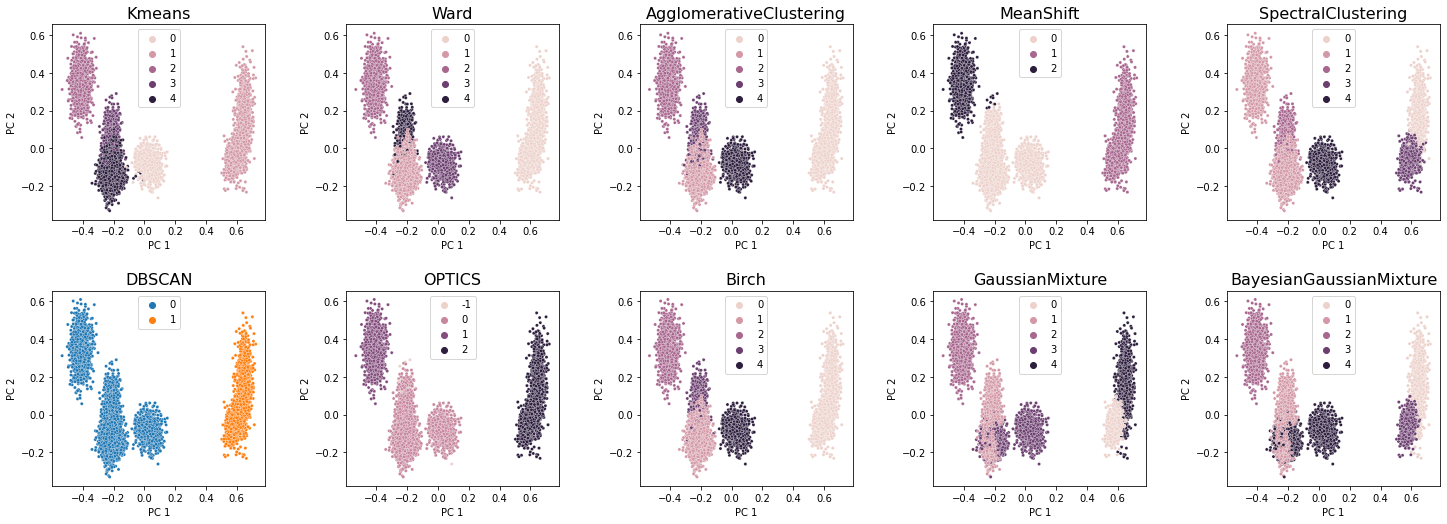

In [13]:
fig, axes = plt.subplots(int(len(datasets)*2), int(len(clustering_algorithms)/2), figsize=(20, 7))
plt.tight_layout(h_pad=5, w_pad=5)
for ax, col in zip(axes.flatten(), labels.columns):
    print(ax, col)
    sns.scatterplot(data=results, ax=ax,
                    x=results['PC 1'], y=results['PC 2'], s=10, hue=col)
    handles, lab = ax.get_legend_handles_labels()
    ax.legend(handles=handles[:], labels=lab[:])

    ax.set_title(col.split('_')[1], size=16)

In [205]:
score

""


In [138]:
def grid_csv(X, name, params):

    GSCV = GridSearchCV(algorithm, param_grid = paramCV, scoring = metrics.silhouette_score(X, labels['label_' + name], metric='euclidean'), cv = 5, n_jobs=-1, verbose=True)
    best_clf = GSCV.fit(X)
    best_hyperparams = best_clf.best_params_
    return name, best_hyperparams

In [63]:
from sklearn.model_selection import GridSearchCV
best_model_stack = list()

#paramCV = {'quantile': np.arange(0.1, 0.3, 0.02) #for bandwidth of RBF kernel in meanshift
#                 'eps': .3, #max distance between 2 samples for DBSCAN
#                 'damping': .1, #for Affinity Propagation:the extent to which the current value is maintained relative to incoming values
#                 'preference': -200, #for Affinity Propagation: each point - points with larger values of preferences are more likely to be chosen as exemplars.
#                 'n_neighbors': 2, #for k-neighbors graph for the connectivity matrix
#                 'n_clusters': 4, #for kmeans, ward, spectral, meanshift
#                 #for kmeans determine on elbow cf model_kmeans_simulated.ipynb
#                 'min_samples': 3, #fot OPTICS The number of samples in a neighborhood for a point to be considered as a core point
#                 'xi': 0.05, #for OPTICS Determines the minimum steepness on the reachability plot that constitutes a cluster boundary.
#                 'min_cluster_size': 0.1, # for optics Minimum number of samples in an OPTICS cluster, expressed as an absolute number or a fraction of the number of samples
#                 'random_state': random_state
#                }
#          ('Kmeans', two_means),
#         #('AffinityPropagation', affinity_propagation), EXCLUDED becuase of high complexity, most appropriate for small to medium sized datasets
#         ('MeanShift', ms),
#         ('SpectralClustering', spectral),
#         ('Ward', ward),
#         ('AgglomerativeClustering', average_linkage),
#         ('DBSCAN', dbscan),
#         ('OPTICS', optics),
#         ('Birch', birch),
#         ('GaussianMixture', gmm)
for name, algorithm in clustering_algorithms:
    if name == 'Kmeans':
        paramCV = {'n_clusters': [2 ,3 ,4, 5, 6]}
        best_model_stack.append(grid_csv(X, name, params))



ValueError: scoring should either be a single string or callable for single metric evaluation or a list/tuple of strings or a dict of scorer name mapped to the callable for multiple metric evaluation. Got 0.35457718284766193 of type <class 'numpy.float64'>